In [1]:
import pandas as pd
import numpy as np
import os
import glob

pd.options.display.max_columns = None
pd.options.display.max_rows = None

inpath = '/slurm_storage/mbopf/projects/MFM_bopf/src/multi_predict/'
outpath = '/MFMDatasets/MFM_bopf/src/multi_predict/results/'
#out_flag = True
out_flag = False

#alg = "LR"
#ROC_CUTOFF = 0.805
#alg_cols = ['target','under_alg','sample_tts','p_C','p_solver','seed','precision_macro','recall_macro','F1_macro','PR_AUC','ROC_AUC','MCC']

#alg = "NB"
#alg_cols = ['target','under_alg','p_var_smoothing','seed','ROC_AUC','MCC']

alg = "SVC"
ROC_CUTOFF = 0.790
alg_cols = ['target','under_alg','sample_tts','TP','FN','FP','TN','p_C','p_kernel','p_degree','seed','precision_macro','recall_macro','F1_macro','PR_AUC','ROC_AUC','MCC']
#alg_cols = ['target','under_alg','p_C','p_kernel','p_degree','seed','precision_macro','recall_macro','F1_macro','PR_AUC','ROC_AUC','MCC']
#alg_cols = ['CLF_time(min)','target','under_alg','p_C','p_kernel','p_degree','p_gamma','seed','ROC_AUC','MCC']

#alg = "MLP"
#ROC_CUTOFF = 0.805
#ROC_CUTOFF = 0.80
#alg_cols = ['target','under_alg','p_activation','p_alpha','p_hidden_layer_sizes','p_random_state','p_solver','seed','ROC_AUC','MCC']
#alg_cols = ['target','sample_tts','p_activation','p_alpha','p_hidden_layer_sizes','seed','p_solver','precision_macro','recall_macro','F1_macro','PR_AUC','ROC_AUC','MCC']

#alg = "RF"
#ROC_CUTOFF = 0.805
#alg_cols = ['target','under_alg','seed','p_n_estimators','p_max_depth','p_min_samples_leaf','p_min_samples_split','ROC_AUC','MCC']
#alg_cols = ['target','under_alg','seed','p_n_estimators','p_max_depth','p_min_samples_leaf','p_min_samples_split','precision_macro','recall_macro','F1_macro','PR_AUC','ROC_AUC','MCC']
#alg_cols = ['target','under_alg','sample_tts','seed','p_n_estimators','p_max_depth','p_min_samples_leaf','p_min_samples_split','precision_macro','recall_macro','F1_macro','acc','PR_AUC','ROC_AUC','MCC']

#alg = "GB"
#ROC_CUTOFF = 0.805
#alg_cols = ['target','under_alg','sample_tts','seed','p_random_state','p_n_estimators','p_max_depth','p_subsample','p_learning_rate','precision_macro','recall_macro','F1_macro','acc','PR_AUC','ROC_AUC','MCC']

os.chdir(inpath + alg + '/output')
#os.chdir(inpath + alg + '/Oct2020/output')
#os.chdir(inpath + alg + '/Nov2020/output')

#dataset = "transfus_yes"
#dataset = "Hysterectomy"
dataset = "*"
#dataset = "trans*"
ext = '.csv'
glob_string = dataset + "*-" + alg + "-*"
files = glob.glob(glob_string + ext)
#files = glob.glob("*-" + alg + "-*" + ext)
#files = glob.glob("transfus_yes*-" + alg + "-*" + ext)

results_df = pd.DataFrame()
#os.chdir('/slurm_storage/mbopf/projects/MFM_bopf/src/multi_predict/MLP/output')
#os.chdir('/slurm_storage/mbopf/projects/MFM_bopf/src/multi_predict/SVC/output')
#os.chdir('/MFMDatasets/MFM_bopf/src/multi_predict/NB/output')
#files = glob.glob("*-NB-*.csv")
#files = glob.glob("*-MLP-*.csv")
#files = glob.glob("*-SVC-*.csv")
#files = glob.glob("transfus_yes*-MLP-*.csv")
#files = glob.glob("transfus_yes*-MLP-*]_0.*_500*.csv")
#files = glob.glob("transfus_hyster*-MLP-*.csv")
#files = glob.glob("transfus_yes*-MLP-*.csv")
#files = glob.glob("transfus_yes*-MLP-*.csv")
len(files)

50

In [2]:
files = sorted(files, reverse=True)
for i in range(len(files)-1):
    if files[i][:-20] == files[i+1][:-20]:
        print(f'DUP:{files[i]}')
print(f'len(files) = {len(files)}')

len(files) = 50


In [3]:
prev_f = ""
for idx, f in enumerate(files):
    print(f'idx={idx}; file={f}')
    if prev_f[:-20] == f[:-20]:   #if the filenames only differ by timestamp
        print(f'DUP:{prev_f}')
        continue   #skip "duplicate"
        
    if results_df.empty:
        results_df = pd.read_csv(f, header=None, index_col=0, names=[idx])
    else:
        this_df = pd.read_csv(f, header=None, index_col=0, names=[idx])
        results_df = results_df.merge(this_df, left_index=True, right_index=True, how="right")
    prev_f = f
results_df

idx=0; file=transfus_yes-1-RAND-SVC-1_0_scale_linear_100000000_1_7-1-1.0-20201216_170545.csv
idx=1; file=transfus_yes-1-RAND-SVC-10_0_scale_linear_100000000_1_7-1-1.0-20201216_170542.csv
idx=2; file=transfus_yes-1-RAND-SVC-100_0_scale_linear_100000000_1_7-1-1.0-20201216_170532.csv
idx=3; file=transfus_yes-1-RAND-SVC-1000_0_scale_linear_100000000_1_7-1-1.0-20201216_170546.csv
idx=4; file=transfus_yes-1-RAND-SVC-10000_0_scale_poly_100000000_1_7-1-1.0-20201216_170041.csv
idx=5; file=transfus_yes-1-RAND-SVC-10000_0_scale_linear_100000000_1_7-1-1.0-20201216_170547.csv
idx=6; file=transfus_yes-1-RAND-SVC-10000_0_auto_poly_100000000_1_7-1-1.0-20201216_170042.csv
idx=7; file=transfus_yes-1-RAND-SVC-100000_0_scale_poly_100000000_1_7-1-1.0-20201216_170042.csv
idx=8; file=transfus_yes-1-RAND-SVC-100000_0_scale_linear_100000000_1_7-1-1.0-20201216_170541.csv
idx=9; file=transfus_yes-1-RAND-SVC-100000_0_auto_poly_100000000_1_7-1-1.0-20201216_170042.csv
idx=10; file=transfus_yes-1-RAND-SVC-1000000_0_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
CLF_time(min),7.921,7.869,7.693,7.935,0.354,7.943,0.357,0.361,7.846,0.363,0.343,7.585,0.370,0.361,7.775,0.355,0.366,5.866,0.366,2.939,251.263,237.146,255.464,256.321,284.907,307.853,303.726,231.224,192.398,187.628,8.086,8.262,8.186,8.107,0.915,8.178,0.904,0.901,8.107,0.918,0.896,7.985,0.893,0.897,7.939,0.877,0.898,6.289,0.875,4.210
target,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes,transfus_yes
under_alg,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND,RAND
pred_alg,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC,SVC
seed,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
samp_strat,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sample_tts,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
p_C,1,10,100,1000,10000,10000,10000,100000,100000,100000,1000000,1000000,1000000,10000000,10000000,10000000,100000000,100000000,100000000,0.1,1,10,100,1000,10000,1000000,100000000,0.1,0.01,0.005,1,10,100,1000,10000,10000,10000,100000,100000,100000,1000000,1000000,1000000,10000000,10000000,10000000,100000000,100000000,100000000,0.1
p_degree,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
p_gamma,scale,scale,scale,scale,scale,scale,auto,scale,scale,auto,scale,scale,auto,scale,scale,auto,scale,scale,auto,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale,auto,scale,scale,auto,scale,scale,auto,scale,scale,auto,scale,scale,auto,scale


In [4]:
results_T = results_df.T
results_T.sort_values(by=['ROC_AUC'], ascending=False, inplace=True)
small = results_T[alg_cols]
small

,target,under_alg,sample_tts,TP,FN,FP,TN,p_C,p_kernel,p_degree,seed,precision_macro,recall_macro,F1_macro,PR_AUC,ROC_AUC,MCC
19,transfus_yes,RAND,1,1291,260,362,1189,0.1,linear,0,1,0.8008,0.7995,0.7993,0.7994,0.8493,0.6003
0,transfus_yes,RAND,1,1341,210,386,1165,1,linear,0,1,0.8119,0.8079,0.8072,0.7945,0.8449,0.6197
49,transfus_yes,RAND,0,1267,284,12777,41296,0.1,linear,0,11,0.5417,0.7903,0.5130,0.1087,0.8445,0.2200
30,transfus_yes,RAND,0,1330,221,14071,40002,1,linear,0,11,0.5404,0.7986,0.5027,0.1064,0.8400,0.2198
2,transfus_yes,RAND,1,1371,180,447,1104,100,linear,0,1,0.8070,0.7979,0.7964,0.7871,0.8359,0.6048
1,transfus_yes,RAND,1,1366,185,424,1127,10,linear,0,1,0.8111,0.8037,0.8025,0.7857,0.8347,0.6147
8,transfus_yes,RAND,1,1379,172,435,1116,100000,linear,0,1,0.8133,0.8043,0.8029,0.7842,0.8330,0.6176
3,transfus_yes,RAND,1,1368,183,440,1111,1000,linear,0,1,0.8076,0.7992,0.7978,0.7823,0.8316,0.6067
35,transfus_yes,RAND,0,1339,212,15342,38731,10000,linear,0,11,0.5374,0.7898,0.4898,0.1023,0.8315,0.2083
5,transfus_yes,RAND,1,1373,178,476,1075,10000,linear,0,1,0.8003,0.7892,0.7872,0.7828,0.8308,0.5893


In [5]:
if out_flag:
    if dataset == '*':
        small.to_csv(outpath + alg + '-ALL-ROC-Results.csv')
    elif dataset == 'trans*':
        small.to_csv(outpath + alg + '-TRANS-ROC-Results.csv')
    else:
        small.to_csv(outpath + alg + "-" + dataset + '-ROC-Results.csv')

In [6]:
# already in the correct directory from above: os.chdir(inpath + alg + '/output')
ext = '.out'
#files = glob.glob("*-" + alg + "-*" + ext)
#files = glob.glob("Hyster" + glob_prefix + ext)
files = glob.glob(glob_string + ext)
print(f'len(files) = {len(files)}')


len(files) = 49


In [7]:
files = sorted(files, reverse=True)
for i in range(len(files)-1):
    print(f'i={i}; file={files[i]}')
    if files[i][:-20] == files[i+1][:-20]:
        print(f'{files[i]}')
print(f'len(files) = {len(files)}')

i=0; file=transfus_yes-1-RAND-SVC-1_0_scale_linear_100000000_1_7-1-1.0-20201216_170545.out
i=1; file=transfus_yes-1-RAND-SVC-10_0_scale_linear_100000000_1_7-1-1.0-20201216_170542.out
i=2; file=transfus_yes-1-RAND-SVC-100_0_scale_linear_100000000_1_7-1-1.0-20201216_170532.out
i=3; file=transfus_yes-1-RAND-SVC-1000_0_scale_linear_100000000_1_7-1-1.0-20201216_170546.out
i=4; file=transfus_yes-1-RAND-SVC-10000_0_scale_poly_100000000_1_7-1-1.0-20201216_170041.out
i=5; file=transfus_yes-1-RAND-SVC-10000_0_scale_linear_100000000_1_7-1-1.0-20201216_170547.out
i=6; file=transfus_yes-1-RAND-SVC-10000_0_auto_poly_100000000_1_7-1-1.0-20201216_170042.out
i=7; file=transfus_yes-1-RAND-SVC-100000_0_scale_poly_100000000_1_7-1-1.0-20201216_170042.out
i=8; file=transfus_yes-1-RAND-SVC-100000_0_scale_linear_100000000_1_7-1-1.0-20201216_170541.out
i=9; file=transfus_yes-1-RAND-SVC-100000_0_auto_poly_100000000_1_7-1-1.0-20201216_170042.out
i=10; file=transfus_yes-1-RAND-SVC-1000000_0_scale_poly_100000000_1

In [8]:
from tokenize import tokenize

high_coeff_files = set()
pd.options.display.float_format = '{:,.4f}'.format
prev_f = ""
coeffs_df = pd.DataFrame()
coeffs_rank_df = pd.DataFrame()
for idx, f in enumerate(files):
    print(f'idx={idx}; file={f}')
    if prev_f[:-20] == f[:-20]:   #if the filenames only differ by timestamp
        print(f'{prev_f}')
        continue   #skip "duplicate"
 
    with open(f, 'r') as file:
        found_coef = False
        cutoff = False
        coef_series = pd.Series()
        ind_vars = []
        coef_vals = []
        for line in file:
            # Add ROC_AUC cutoff
            if "ROC_AUC" in line:
                roc_auc = line.split()[2]   
                if float(roc_auc) < ROC_CUTOFF:
                    cutoff = True
                    #print(f'roc_auc = {roc_auc}; idx={idx}; cutoff = {cutoff}')
                    break    # Stop processing this file; poor performance
            
            if "coeffs =" in line:
                found_coef = True
                #print(f"found_coef: idx={idx}; file={f}")
                continue
            
            if found_coef:
                var_coef = line.split()
                if var_coef[0] != 'dtype:':
                    ind_vars.append(var_coef[0])
                    coef_vals.append(float(var_coef[1]))
                    if float(var_coef[1]) > 100:
                        high_coeff_files.add(f)
                
        if not cutoff and found_coef:
            if coeffs_df.empty:
                coeffs_df = pd.DataFrame(data=coef_vals, index=ind_vars, columns=[idx])
                coeffs_rank_df = pd.DataFrame(data=coeffs_df[idx].rank(ascending=False).astype(int), columns=[idx])
            else:
                this_df = pd.DataFrame(data=coef_vals, index=ind_vars, columns=[idx])
                this_rank_df = pd.DataFrame(data=this_df[idx].rank(ascending=False).astype(int), columns=[idx])
                coeffs_df = coeffs_df.merge(this_df, left_index=True, right_index=True, how="left")
                coeffs_rank_df = coeffs_rank_df.merge(this_rank_df, left_index=True, right_index=True, how="left")

    prev_f = f
    
coeffs_df

idx=0; file=transfus_yes-1-RAND-SVC-1_0_scale_linear_100000000_1_7-1-1.0-20201216_170545.out
idx=1; file=transfus_yes-1-RAND-SVC-10_0_scale_linear_100000000_1_7-1-1.0-20201216_170542.out
idx=2; file=transfus_yes-1-RAND-SVC-100_0_scale_linear_100000000_1_7-1-1.0-20201216_170532.out
idx=3; file=transfus_yes-1-RAND-SVC-1000_0_scale_linear_100000000_1_7-1-1.0-20201216_170546.out
idx=4; file=transfus_yes-1-RAND-SVC-10000_0_scale_poly_100000000_1_7-1-1.0-20201216_170041.out
idx=5; file=transfus_yes-1-RAND-SVC-10000_0_scale_linear_100000000_1_7-1-1.0-20201216_170547.out
idx=6; file=transfus_yes-1-RAND-SVC-10000_0_auto_poly_100000000_1_7-1-1.0-20201216_170042.out
idx=7; file=transfus_yes-1-RAND-SVC-100000_0_scale_poly_100000000_1_7-1-1.0-20201216_170042.out
idx=8; file=transfus_yes-1-RAND-SVC-100000_0_scale_linear_100000000_1_7-1-1.0-20201216_170541.out


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


idx=9; file=transfus_yes-1-RAND-SVC-100000_0_auto_poly_100000000_1_7-1-1.0-20201216_170042.out
idx=10; file=transfus_yes-1-RAND-SVC-1000000_0_scale_poly_100000000_1_7-1-1.0-20201216_170041.out
idx=11; file=transfus_yes-1-RAND-SVC-1000000_0_scale_linear_100000000_1_7-1-1.0-20201216_170525.out
idx=12; file=transfus_yes-1-RAND-SVC-1000000_0_auto_poly_100000000_1_7-1-1.0-20201216_170043.out
idx=13; file=transfus_yes-1-RAND-SVC-10000000_0_scale_poly_100000000_1_7-1-1.0-20201216_170042.out
idx=14; file=transfus_yes-1-RAND-SVC-10000000_0_scale_linear_100000000_1_7-1-1.0-20201216_170537.out
idx=15; file=transfus_yes-1-RAND-SVC-10000000_0_auto_poly_100000000_1_7-1-1.0-20201216_170042.out
idx=16; file=transfus_yes-1-RAND-SVC-100000000_0_scale_poly_100000000_1_7-1-1.0-20201216_170042.out
idx=17; file=transfus_yes-1-RAND-SVC-100000000_0_scale_linear_100000000_1_7-1-1.0-20201216_170342.out
idx=18; file=transfus_yes-1-RAND-SVC-100000000_0_auto_poly_100000000_1_7-1-1.0-20201216_170042.out
idx=19; fil

,0,1,2,3,8,11,14,19,29,30,48
Intraabrupt,2.2743,17.5674,168.5416,"1,654.6421","187,594.5872","1,780,058.0000","18,767,620.0000",0.8605,0.6167,9.4199,0.7135
previa9,1.8528,10.9508,108.5220,"1,195.3939","115,048.0090","1,000,000.0000","11,978,050.0000",0.8785,2.0555,14.7272,0.7809
Anteanemia,1.1671,6.8835,68.2635,758.8059,"77,846.6006","629,275.3000","8,344,319.0000",0.1926,1.3183,7.3452,0.2063
previa_chart,1.0388,4.4253,38.4895,396.7257,"25,330.7677","325,847.6000","3,622,052.0000",0.5785,0.1761,0.3833,0.4880
BESTGA,1.0323,10.6199,100.5444,987.5186,"101,069.6135","884,903.0000","10,070,370.0000",0.1002,1.2844,9.4203,0.0187
ga,1.0009,10.4841,98.3627,990.0586,"98,702.6463","874,113.1000","9,942,299.0000",0.0769,1.1999,9.0955,0.0455
HosEpiNurse,0.9699,5.9531,59.1194,699.5973,"61,803.8182","475,748.4000","6,099,258.0000",0.4116,1.0488,5.6483,0.4192
IntraMgSO,0.8559,3.0368,31.5600,131.6086,"30,833.0064","283,288.2000","2,618,887.0000",0.5762,0.9496,4.2344,0.4071
Antesteroid,0.6833,3.7384,38.2156,564.5797,"33,865.5851","296,256.7000","4,519,317.0000",0.1770,0.3805,3.3862,0.0611
Ind_elect,0.5501,4.0462,45.5088,397.3738,"40,404.8208","406,004.4000","3,338,318.0000",0.0268,0.4080,3.5099,0.0255


In [9]:
if out_flag:
    if dataset == '*':
        coeffs_df.to_csv(outpath + alg + '-ALL-coeffs.csv')
    elif dataset == 'trans*':
        coeffs_df.to_csv(outpath + alg + '-TRANS-coeffs.csv')
    else:
        coeffs_df.to_csv(outpath + alg + "-" + dataset + '-coeffs.csv')

In [10]:
coeffs_rank_df['mean_rank'] = coeffs_rank_df.apply(np.mean, axis=1).rank().astype(int)
coeffs_rank_df = coeffs_rank_df.astype('Int8')
coeffs_rank_df.sort_values('mean_rank', inplace=True)
coeffs_rank_df

,0,1,2,3,8,11,14,19,29,30,48,mean_rank
previa9,2,2,2,2,2,2,2,1,1,1,1,1
Intraabrupt,1,1,1,1,1,1,1,2,8,3,2,2
Anteanemia,3,5,6,5,5,5,5,9,2,5,9,3
BESTGA,5,3,3,4,3,3,3,13,3,2,24,4
ga,6,4,4,3,4,4,4,15,4,4,17,5
HosEpiNurse,7,7,7,7,6,7,7,7,5,7,6,6
abruption,12,13,14,13,11,9,13,3,7,8,2,7
Anteabruption,24,6,5,6,7,6,6,18,17,6,13,8
previa_chart,4,9,10,10,15,11,9,4,21,25,4,9
Antesteroid,9,12,12,8,12,13,8,10,13,11,16,10


In [11]:
if out_flag:
    if dataset == '*':
        coeffs_rank_df.to_csv(outpath + alg + '-ALL-coef_rank.csv')
    elif dataset == 'trans*':
        coeffs_rank_df.to_csv(outpath + alg + '-TRANS-coef_rank.csv')
    else:
        coeffs_rank_df.to_csv(outpath + alg + "-" + dataset + '-coef_rank.csv')

In [12]:
coeffs_rank_inv = coeffs_rank_df.T
#combo = pd.concat([small, coeffs_rank_inv['abruptio9']], axis=1, join='inner')
combo = pd.concat([small, coeffs_rank_inv], axis=1, join='inner')
combo

,target,under_alg,sample_tts,TP,FN,FP,TN,p_C,p_kernel,p_degree,seed,precision_macro,recall_macro,F1_macro,PR_AUC,ROC_AUC,MCC,previa9,Intraabrupt,Anteanemia,BESTGA,ga,HosEpiNurse,abruption,Anteabruption,previa_chart,Antesteroid,IntraMgSO,Ind_elect,Anteprevia,Intratocolytix,MthInd_AROM,Ind_Unkn,abruptio9,Delmode,AB_ceph,HosEpitype,ThreatenedPB,MthInd_Oxy,DMControl,Delfetalpos,high_height,Education,HospElectCS,Admconsistency,HxnumCS,Dilat_lst,AdmBishop,Meconium,Admreason,Admcervpos,HospElectInd,Episiotomy,Operative,ROMmeth,Marital,Parity,Presentdel,AdmSBP,AdmDBP,Admpresent,Inoxy_incrdose,Admefface,Admcontract,Augment
19,transfus_yes,RAND,1,1291,260,362,1189,0.1,linear,0,1,0.8008,0.7995,0.7993,0.7994,0.8493,0.6003,1,2,9,13,15,7,3,18,4,10,5,22,6,8,12,16,14,17,21,19,11,20,25,26,35,23,30,36,27,37,33,28,31,32,24,34,38,41,29,39,40,46,43,44,45,47,42,48
0,transfus_yes,RAND,1,1341,210,386,1165,1,linear,0,1,0.8119,0.8079,0.8072,0.7945,0.8449,0.6197,2,1,3,5,6,7,12,24,4,9,8,10,21,13,11,15,17,14,20,18,16,19,22,23,35,25,34,29,28,32,30,26,36,37,27,31,41,39,33,43,38,40,42,48,44,45,47,46
48,transfus_yes,RAND,0,1267,284,12777,41296,0.1,linear,0,11,0.5417,0.7903,0.5130,0.1087,0.8445,0.2200,1,2,9,24,17,6,2,13,4,16,7,21,4,8,37,10,11,14,23,18,12,15,36,27,32,20,40,19,22,31,28,25,35,34,38,39,33,30,26,29,46,44,41,47,45,42,43,48
29,transfus_yes,RAND,0,1330,221,14071,40002,1,linear,0,11,0.5404,0.7986,0.5027,0.1064,0.8400,0.2198,1,8,2,3,4,5,7,17,21,13,6,12,21,9,25,11,18,14,15,19,10,16,23,26,20,27,30,24,31,28,46,39,34,41,33,37,32,36,29,35,38,40,47,43,45,44,42,48
2,transfus_yes,RAND,1,1371,180,447,1104,100,linear,0,1,0.8070,0.7979,0.7964,0.7871,0.8359,0.6048,2,1,6,3,4,7,14,5,10,12,13,8,10,16,9,15,20,17,18,21,37,19,23,22,31,24,41,27,32,28,26,34,36,33,38,29,35,25,39,30,40,43,48,42,45,44,46,47
1,transfus_yes,RAND,1,1366,185,424,1127,10,linear,0,1,0.8111,0.8037,0.8025,0.7857,0.8347,0.6147,2,1,5,3,4,7,13,6,9,12,14,11,9,15,8,16,17,18,20,19,25,21,23,24,26,28,22,27,32,30,34,29,33,35,37,31,38,41,36,43,39,40,45,42,44,46,48,47
8,transfus_yes,RAND,1,1379,172,435,1116,100000,linear,0,1,0.8133,0.8043,0.8029,0.7842,0.8330,0.6176,2,1,5,3,4,6,11,7,15,12,13,9,15,18,10,14,8,20,17,21,30,22,23,24,25,32,19,33,35,29,27,34,26,31,28,42,40,36,39,37,38,41,44,46,45,43,48,47
3,transfus_yes,RAND,1,1368,183,440,1111,1000,linear,0,1,0.8076,0.7992,0.7978,0.7823,0.8316,0.6067,2,1,5,4,3,7,13,6,10,8,21,9,10,15,12,20,14,17,16,18,26,23,19,24,25,33,22,29,35,32,27,38,30,28,36,47,31,37,41,34,39,40,42,43,44,45,48,46
30,transfus_yes,RAND,0,1354,197,15757,38316,10,linear,0,11,0.5370,0.7908,0.4864,0.1029,0.8301,0.2075,1,3,5,2,4,7,8,6,25,11,9,10,25,12,15,13,14,17,16,19,23,47,20,22,18,27,31,21,30,32,33,35,34,36,39,24,38,29,28,37,40,42,44,41,45,48,43,46
11,transfus_yes,RAND,1,1362,189,432,1119,1000000,linear,0,1,0.8074,0.7998,0.7986,0.7822,0.8294,0.6071,2,1,5,3,4,7,9,6,11,13,15,8,11,14,10,17,16,19,18,22,20,23,25,26,24,34,21,32,30,29,31,28,33,27,37,41,35,40,48,36,39,38,42,45,43,44,46,47


In [13]:
if out_flag:
    if dataset == '*':
        combo.to_csv(outpath + alg + '-ALL-combo.csv')
    elif dataset == 'trans*':
        combo.to_csv(outpath + alg + '-TRANS-combo.csv')
    else:
        combo.to_csv(outpath + alg + "-" + dataset + '-combo.csv')

In [14]:
coeffs_df_inv = coeffs_df.T
#combo2 = pd.concat([combo, coeffs_df_inv['abruptio9']], axis=1, join='inner')
combo2 = pd.concat([combo, coeffs_df_inv], axis=1, join='inner')
combo2
#combo2.sort_values('abruptio9', inplace=True) # Can't do this because there are two "abruptio9" cols

,target,under_alg,sample_tts,TP,FN,FP,TN,p_C,p_kernel,p_degree,seed,precision_macro,recall_macro,F1_macro,PR_AUC,ROC_AUC,MCC,previa9,Intraabrupt,Anteanemia,BESTGA,ga,HosEpiNurse,abruption,Anteabruption,previa_chart,Antesteroid,IntraMgSO,Ind_elect,Anteprevia,Intratocolytix,MthInd_AROM,Ind_Unkn,abruptio9,Delmode,AB_ceph,HosEpitype,ThreatenedPB,MthInd_Oxy,DMControl,Delfetalpos,high_height,Education,HospElectCS,Admconsistency,HxnumCS,Dilat_lst,AdmBishop,Meconium,Admreason,Admcervpos,HospElectInd,Episiotomy,Operative,ROMmeth,Marital,Parity,Presentdel,AdmSBP,AdmDBP,Admpresent,Inoxy_incrdose,Admefface,Admcontract,Augment,Intraabrupt,previa9,Anteanemia,previa_chart,BESTGA,ga,HosEpiNurse,IntraMgSO,Antesteroid,Ind_elect,MthInd_AROM,abruption,Intratocolytix,Delmode,Ind_Unkn,ThreatenedPB,abruptio9,HosEpitype,MthInd_Oxy,AB_ceph,Anteprevia,DMControl,Delfetalpos,Anteabruption,Education,Meconium,HospElectInd,HxnumCS,Admconsistency,AdmBishop,Episiotomy,Dilat_lst,Marital,HospElectCS,high_height,Admreason,Admcervpos,Presentdel,ROMmeth,AdmSBP,Operative,AdmDBP,Parity,Inoxy_incrdose,Admefface,Augment,Admcontract,Admpresent
19,transfus_yes,RAND,1,1291,260,362,1189,0.1,linear,0,1,0.8008,0.7995,0.7993,0.7994,0.8493,0.6003,1,2,9,13,15,7,3,18,4,10,5,22,6,8,12,16,14,17,21,19,11,20,25,26,35,23,30,36,27,37,33,28,31,32,24,34,38,41,29,39,40,46,43,44,45,47,42,48,0.8605,0.8785,0.1926,0.5785,0.1002,0.0769,0.4116,0.5762,0.1770,0.0268,0.1008,0.7547,0.2541,0.0673,0.0707,0.1460,0.0942,0.0433,0.0322,0.0294,0.4785,0.0219,0.0216,0.0547,0.0241,0.0113,0.0220,0.0209,0.0067,0.0081,0.0081,0.0056,0.0104,0.0101,0.0069,0.0092,0.0085,0.0013,0.0005,0.0001,0.0029,0.0002,0.0025,0.0002,0.0001,0.0000,0.0005,0.0002
0,transfus_yes,RAND,1,1341,210,386,1165,1,linear,0,1,0.8119,0.8079,0.8072,0.7945,0.8449,0.6197,2,1,3,5,6,7,12,24,4,9,8,10,21,13,11,15,17,14,20,18,16,19,22,23,35,25,34,29,28,32,30,26,36,37,27,31,41,39,33,43,38,40,42,48,44,45,47,46,2.2743,1.8528,1.1671,1.0388,1.0323,1.0009,0.9699,0.8559,0.6833,0.5501,0.4577,0.4002,0.3939,0.3370,0.3091,0.2786,0.2741,0.2400,0.2072,0.1863,0.1860,0.1765,0.1271,0.1259,0.0812,0.0790,0.0578,0.0407,0.0361,0.0354,0.0308,0.0291,0.0239,0.0206,0.0177,0.0171,0.0159,0.0111,0.0048,0.0034,0.0033,0.0011,0.0011,0.0010,0.0008,0.0005,0.0001,0.0001
48,transfus_yes,RAND,0,1267,284,12777,41296,0.1,linear,0,11,0.5417,0.7903,0.5130,0.1087,0.8445,0.2200,1,2,9,24,17,6,2,13,4,16,7,21,4,8,37,10,11,14,23,18,12,15,36,27,32,20,40,19,22,31,28,25,35,34,38,39,33,30,26,29,46,44,41,47,45,42,43,48,0.7135,0.7809,0.2063,0.4880,0.0187,0.0455,0.4192,0.4071,0.0611,0.0255,0.0037,0.7135,0.2641,0.0626,0.1217,0.1049,0.1103,0.0443,0.0618,0.0197,0.4880,0.0039,0.0121,0.1030,0.0260,0.0174,0.0027,0.0199,0.0294,0.0109,0.0024,0.0073,0.0153,0.0014,0.0071,0.0042,0.0052,0.0003,0.0092,0.0003,0.0063,0.0008,0.0095,0.0003,0.0005,0.0002,0.0004,0.0002
29,transfus_yes,RAND,0,1330,221,14071,40002,1,linear,0,11,0.5404,0.7986,0.5027,0.1064,0.8400,0.2198,1,8,2,3,4,5,7,17,21,13,6,12,21,9,25,11,18,14,15,19,10,16,23,26,20,27,30,24,31,28,46,39,34,41,33,37,32,36,29,35,38,40,47,43,45,44,42,48,0.6167,2.0555,1.3183,0.1761,1.2844,1.1999,1.0488,0.9496,0.3805,0.4080,0.0962,0.7019,0.4529,0.3600,0.4182,0.4338,0.2416,0.2250,0.2862,0.3056,0.1761,0.1408,0.0922,0.2501,0.0864,0.0064,0.0380,0.0422,0.1187,0.0009,0.0181,0.0708,0.0594,0.0430,0.1823,0.0348,0.0028,0.0069,0.0273,0.0029,0.0399,0.0007,0.0331,0.0010,0.0010,0.0002,0.0022,0.0011
2,transfus_yes,RAND,1,1371,180,447,1104,100,linear,0,1,0.8070,0.7979,0.7964,0.7871,0.8359,0.6048,2,1,6,3,4,7,14,5,10,12,13,8,10,16,9,15,20,17,18,21,37,19,23,22,31,24,41,27,32,28,26,34,36,33,38,29,35,25,39,30,40,43,48,42,45,44,46,47,168.5416,108.5220,68.2635,38.4895,100.5444,98.3627,59.1194,31.5600,38.2156,45.5088,43.5031,31.4584,25.1355,21.3510,28.4061,1.1109,11.1409,10.7230,13.0367,20.0397,38.4895,6.7729,7.0378,68.5416,4.0990,1.6460,1.0274,2.2664,3.6936,3.7767,2.8363,3.2287,0.8621,0.4901,2.3764,1.1397,2.0232,0.7185,4.0308,0.1993,1.5752,0.0174,2.8347,0.1443,0.1472,0.0586,0.0897,0.2240
1,transfus

In [15]:
if out_flag:
    if dataset == '*':
        combo2.to_csv(outpath + alg + '-ALL-combo2.csv')
    elif dataset == 'trans*':
        combo2.to_csv(outpath + alg + '-TRANS-combo2.csv')
    else:
        combo2.to_csv(outpath + alg + "-" + dataset + '-combo2.csv')

In [16]:
top_index = small.iloc[0].name
#top_index = 50
files[top_index]

'transfus_yes-1-RAND-SVC-0.1_0_scale_linear_100000000_1_7-1-1.0-20201216_170047.out'

In [17]:
base = files[top_index][:-20]

In [18]:
#path = inpath + alg + '/output/'
ft_glob = base + "*" + '_fpr_tpr.dat'
pr_glob = base + "*" + '_pr.dat'
print(glob.glob(ft_glob))

['transfus_yes-1-RAND-SVC-0.1_0_scale_linear_100000000_1_7-1-1.0-20201216_170047_fpr_tpr.dat']


In [19]:
#fpr, tpr, thresholds = np.loadtxt(glob.glob(ft_glob)[0], delimiter=',')
fpr, tpr = np.loadtxt(glob.glob(ft_glob)[0], delimiter=',')
precision, recall = np.loadtxt(glob.glob(pr_glob)[0], delimiter=',')

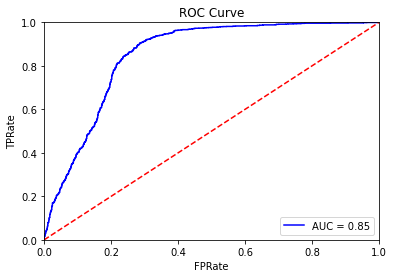

In [20]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPRate')
plt.xlabel('FPRate')
plt.show()

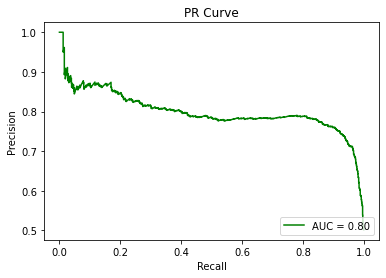

In [21]:
pr_auc = auc(recall, precision)
plt.title('PR Curve')
plt.plot(recall, precision, 'g', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()